# Your first deep neural network

# imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Flatten, Dense, Conv2D
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical

from keras.datasets import cifar10

# W&B integration for experiment tracking
import sys
sys.path.insert(0, '../..')
from utils.wandb_utils import init_wandb, get_metrics_logger
import wandb

2025-12-31 16:05:29.688674: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/cataluna84/Workspace-Antigravity/Generative_Deep_Learning/.venv/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


# data

In [2]:
NUM_CLASSES = 10

In [3]:
# Initialize W&B for experiment tracking
run = init_wandb(
    name="02_01_deep_neural_network",
    config={
        "model": "dense_network",
        "dataset": "cifar10",
        "num_classes": NUM_CLASSES,
        "hidden_layers": [200, 150],
        "learning_rate": 0.0005,
        "batch_size": 1024,
        "epochs": 10,
        "optimizer": "adam",
    }
)

wandb: Currently logged in as: cataluna84 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

/home/cataluna84/Workspace-Antigravity/Generative_Deep_Learning/.venv/lib/python3.13/site-packages/keras/src/datasets/cifar.py:18: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  d = cPickle.load(f, encoding="bytes")


In [5]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

In [6]:
x_train[54, 12, 13, 1] 

np.float32(0.36862746)

# architecture

In [7]:
input_layer = Input((32,32,3))

x = Flatten()(input_layer)

x = Dense(200, activation = 'relu')(x)
x = Dense(150, activation = 'relu')(x)

output_layer = Dense(NUM_CLASSES, activation = 'softmax')(x)

model = Model(input_layer, output_layer)

I0000 00:00:1767197150.212900   13529 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6094 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5


In [8]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 200)            │       614,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 150)            │        30,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 646,260 (2.47 MB)

 Trainable params: 646,260 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

# train

In [9]:
opt = Adam(learning_rate=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [10]:
model.fit(x_train
          , y_train
          , batch_size=1024
          , epochs=10
          , shuffle=True
          , validation_data=(x_test, y_test)  # Added for W&B metrics
          , callbacks=[get_metrics_logger()]  # W&B callback
          )

Epoch 1/10


2025-12-31 16:06:03.064676: I external/local_xla/xla/service/service.cc:163] XLA service 0x761698086180 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-31 16:06:03.064740: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2025-12-31 16:06:03.129490: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-31 16:06:03.461729: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91701
I0000 00:00:1767197166.956514   13716 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


49/49 ━━━━━━━━━━━━━━━━━━━━ 25s 319ms/step - accuracy: 0.2757 - loss: 2.0078 - val_accuracy: 0.3230 - val_loss: 1.8904
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.3579 - loss: 1.8231 - val_accuracy: 0.3776 - val_loss: 1.7768
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.3884 - loss: 1.7410 - val_accuracy: 0.3979 - val_loss: 1.7028
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.4062 - loss: 1.6857 - val_accuracy: 0.4192 - val_loss: 1.6611
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 344ms/step - accuracy: 0.4257 - loss: 1.6343 - val_accuracy: 0.4242 - val_loss: 1.6290
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.4433 - loss: 1.5936 - val_accuracy: 0.4435 - val_loss: 1.5909
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4512 - loss: 1.5653 - val_accuracy: 0.4480 - val_loss: 1.5704
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.4579 - loss: 1.5453 - val_accuracy: 0.4556 - val_lo

# analysis

In [11]:
model.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.4553 - loss: 1.5396


[1.5395753383636475, 0.4553000032901764]

In [12]:
CLASSES = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

preds = model.predict(x_test)
preds_single = CLASSES[np.argmax(preds, axis = -1)]
actual_single = CLASSES[np.argmax(y_test, axis = -1)]

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


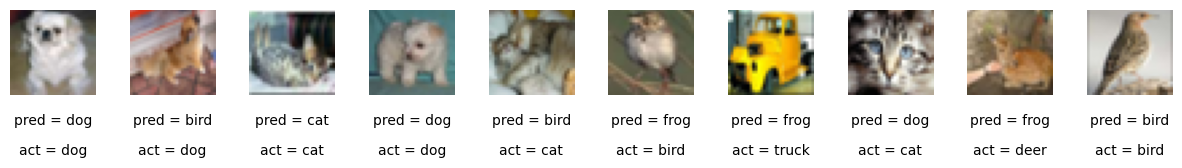

In [13]:

n_to_show = 10
indices = np.random.choice(range(len(x_test)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_test[idx]
    ax = fig.add_subplot(1, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, 'pred = ' + str(preds_single[idx]), fontsize=10, ha='center', transform=ax.transAxes) 
    ax.text(0.5, -0.7, 'act = ' + str(actual_single[idx]), fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(img)


In [14]:
# Finish W&B run
wandb.finish()

epoch/accuracy,▁▄▅▆▆▇▇███
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▄▃▂▂▂▁▁
epoch/val_accuracy,▁▄▅▆▆▇████
epoch/val_loss,█▆▄▃▃▂▂▁▁▁
epoch/accuracy,0.47074
epoch/epoch,9
epoch/learning_rate,0.0005
epoch/loss,1.50168
epoch/val_accuracy,0.4553
